In [55]:
import gymnasium as gym
import numpy as np
import math
from collections import deque
import time

np.random.seed(42)

class MountaincarQAgent():
    def __init__(self, buckets=(20, 20), num_episodes=50000, min_epsilon=0.01, discount=0.99, decay_rate=0.001):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay_rate = decay_rate

        self.env = gym.make('MountainCar-v0')
        self.upper_bounds = self.env.observation_space.high
        self.lower_bounds = self.env.observation_space.low

        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

        self.learning_rate = 0.02
        self.initial_epsilon = 1.0
        self.epsilon = self.initial_epsilon

        self.threshold = self.env.spec.reward_threshold
        print(f'Reward Threshold: {self.threshold}')

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] - self.lower_bounds[i]) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state, terminated):
        if terminated:
            target = reward
        else:
            target = reward + self.discount * np.max(self.Q_table[new_state])
        
        self.Q_table[state][action] += self.learning_rate * (target - self.Q_table[state][action])

    def get_epsilon(self, episode: int) -> float:
        return max(self.min_epsilon,self.initial_epsilon * np.exp(-self.decay_rate * episode))


    def train(self):
        scores_deque = deque(maxlen=100)
        scores_array = []
        avg_scores_array = []
        episode_lengths = []
        print_every = 1000
        time_start = time.time()

        for i_episode in range(self.num_episodes):
            initial_obs, info = self.env.reset()
            current_state = self.discretize_state(initial_obs)
            
            self.epsilon = self.get_epsilon(i_episode)
            terminated  = False
            truncated = False
            episode_reward = 0
            time_step = 0

            while not (terminated or truncated):
                action = self.choose_action(current_state)
                obs, reward, terminated, truncated, info = self.env.step(action)
                new_state = self.discretize_state(obs)

                if terminated:
                    reward += 10
                
                self.update_q(current_state, action, reward, new_state, terminated)
                
                current_state = new_state
                episode_reward += reward
                time_step += 1

            scores_deque.append(episode_reward)
            scores_array.append(episode_reward)
            episode_lengths.append(time_step)
            avg_score = np.mean(scores_deque)
            avg_scores_array.append(avg_score)
            
            s = int(time.time() - time_start)
            
            if i_episode % print_every == 0 and i_episode > 0:
                print(f'Episode: {i_episode}, Score: {episode_reward:5.0f}, Avg.Score: {avg_score:.2f}, Epsilon: {self.epsilon:.3f}, Time: {s//3600:02}:{s%3600//60:02}:{s%60:02}')

            if avg_score >= self.threshold:
                print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
                return scores_array,avg_scores_array, episode_lengths

        print('Finished training but not within the threshold.')
        return scores_array, avg_scores_array , episode_lengths

    def render_trained_agent(self, episodes=3):
        env = gym.make('MountainCar-v0', render_mode='human')
        for e in range(episodes):
            obs, info = env.reset()
            state = self.discretize_state(obs)
            done = False
            t = 0
            while not done:
                action = np.argmax(self.Q_table[state])
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                state = self.discretize_state(obs)
                t += 1
            print(f"Episode {e+1} finished in {t} steps")
        env.close()


In [56]:
agent = MountaincarQAgent()
scores , avg_scores,episode_lengths = agent.train()

Reward Threshold: -110.0
Episode: 1000, Score:  -200, Avg.Score: -200.00, Epsilon: 0.368, Time: 00:00:14
Episode: 2000, Score:  -200, Avg.Score: -200.00, Epsilon: 0.135, Time: 00:00:25
Episode: 3000, Score:  -200, Avg.Score: -195.63, Epsilon: 0.050, Time: 00:00:35
Episode: 4000, Score:  -186, Avg.Score: -199.58, Epsilon: 0.018, Time: 00:00:46
Episode: 5000, Score:  -178, Avg.Score: -181.56, Epsilon: 0.010, Time: 00:00:56
Episode: 6000, Score:  -175, Avg.Score: -165.85, Epsilon: 0.010, Time: 00:01:05
Episode: 7000, Score:  -143, Avg.Score: -159.22, Epsilon: 0.010, Time: 00:01:15
Episode: 8000, Score:  -200, Avg.Score: -159.47, Epsilon: 0.010, Time: 00:01:24
Episode: 9000, Score:  -147, Avg.Score: -154.81, Epsilon: 0.010, Time: 00:01:33
Episode: 10000, Score:  -143, Avg.Score: -166.16, Epsilon: 0.010, Time: 00:01:42
Episode: 11000, Score:  -174, Avg.Score: -157.24, Epsilon: 0.010, Time: 00:01:51
Episode: 12000, Score:  -148, Avg.Score: -154.65, Epsilon: 0.010, Time: 00:01:59
Episode: 130

In [61]:
# watch the trained agent 
agent.render_trained_agent(episodes=3)

Episode 1 finished in 118 steps
Episode 2 finished in 118 steps
Episode 3 finished in 118 steps
Episode 4 finished in 115 steps


length of scores:  31063 , len of avg_scores:  31063


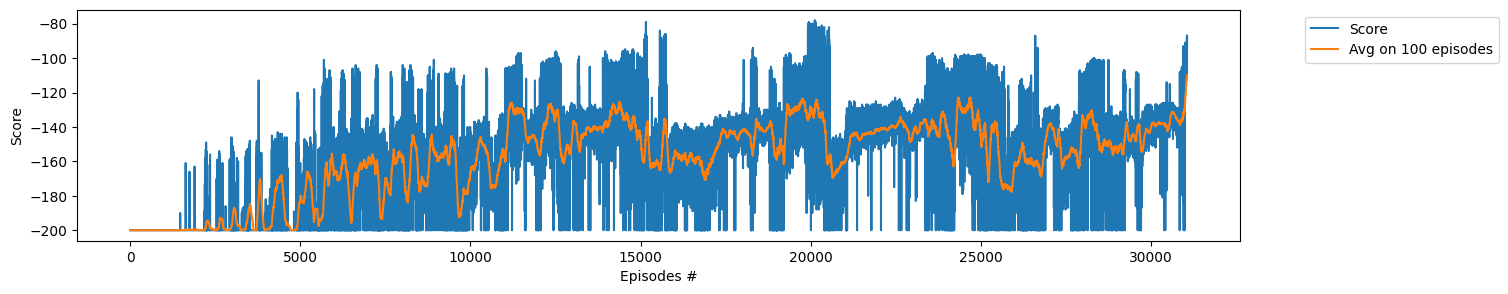

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

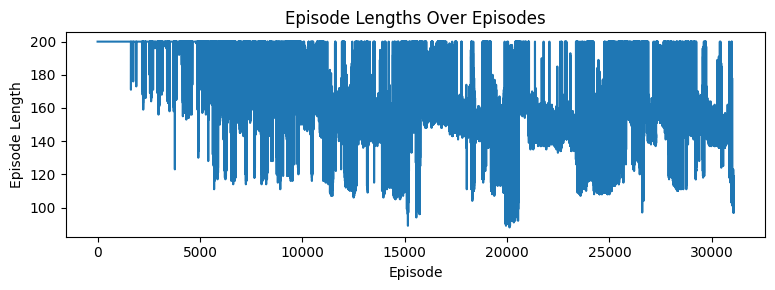

In [67]:
# episode lengths per episode
fig = plt.figure(figsize=(15,3))
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.xlabel('Episode')  
plt.ylabel('Episode Length')  
plt.title('Episode Lengths Over Episodes')  

plt.tight_layout()
plt.show()

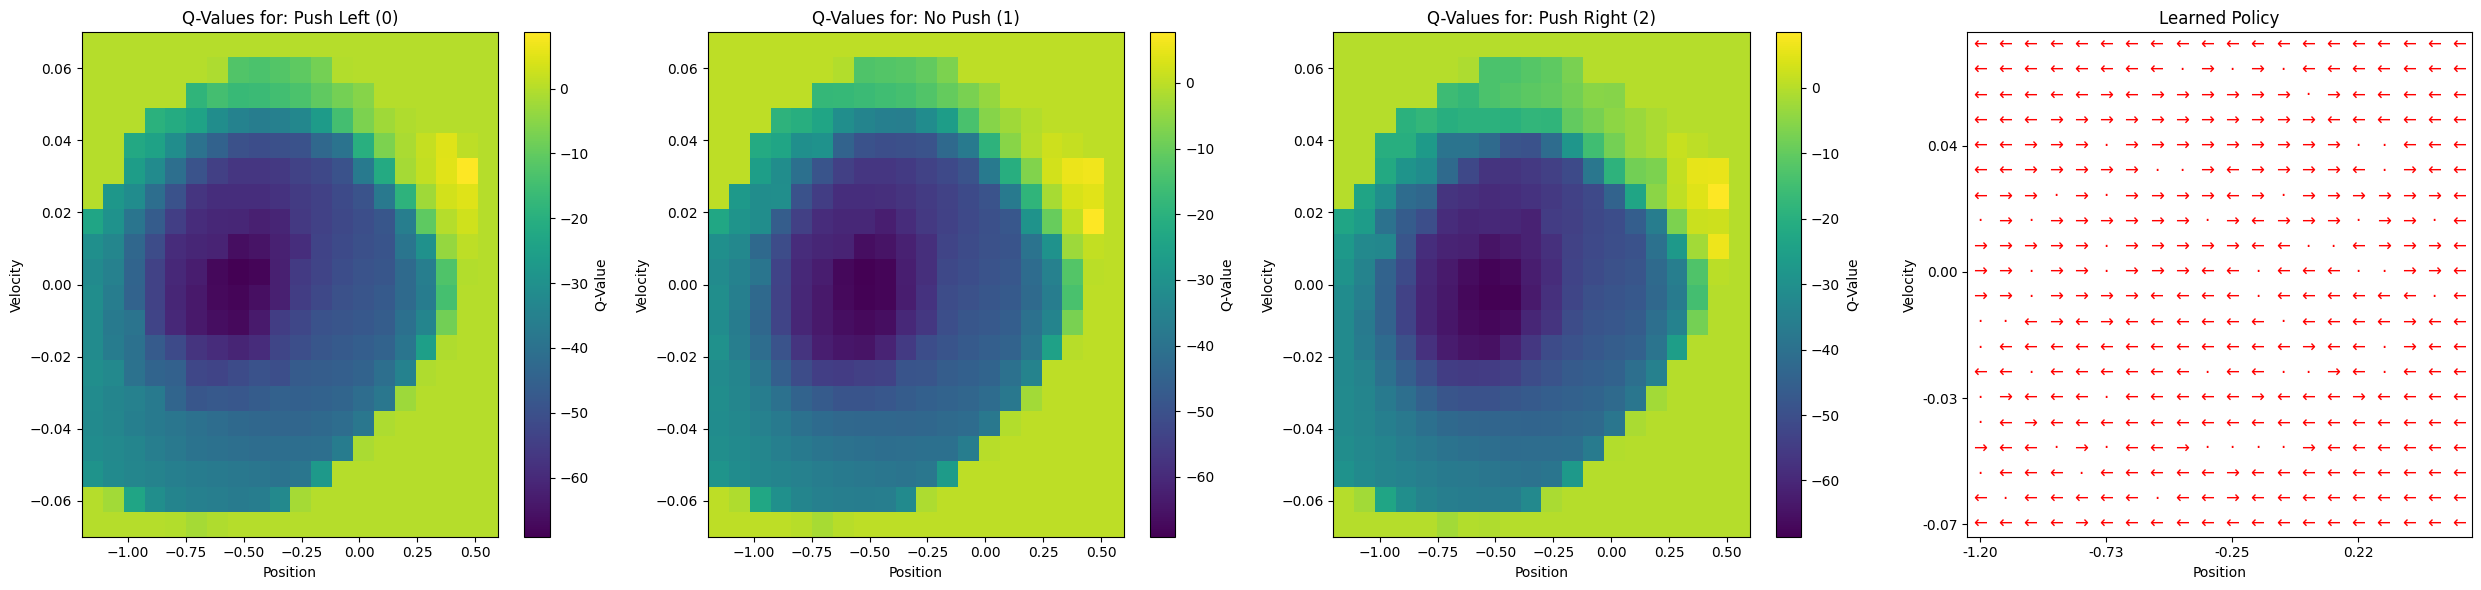

In [68]:
q_table = agent.Q_table
buckets = agent.buckets
lower_bounds = agent.lower_bounds
upper_bounds = agent.upper_bounds

action_space = [0, 1, 2] # 0: Push Left, 1: No Push, 2: Push Right
action_labels = ["Push Left (0)", "No Push (1)", "Push Right (2)"]

position_buckets, velocity_buckets = buckets

fig, axes = plt.subplots(1, len(action_space) + 1, figsize=(25, 6))


for i, action in enumerate(action_space):
    q_values = q_table[:, :, action].T 

    cax = axes[i].imshow(q_values, cmap='viridis', origin='lower', 
                         extent=[lower_bounds[0], upper_bounds[0], lower_bounds[1], upper_bounds[1]], 
                         aspect='auto')

    fig.colorbar(cax, ax=axes[i], label='Q-Value')
    axes[i].set_title(f"Q-Values for: {action_labels[i]}")
    axes[i].set_xlabel("Position")
    axes[i].set_ylabel("Velocity")

policy_ax = axes[-1]

pos_tick_indices = np.arange(0, position_buckets, 5)
vel_tick_indices = np.arange(0, velocity_buckets, 5)

pos_tick_labels = np.linspace(lower_bounds[0], upper_bounds[0], position_buckets)[pos_tick_indices]
vel_tick_labels = np.linspace(lower_bounds[1], upper_bounds[1], velocity_buckets)[vel_tick_indices]

policy_ax.imshow(np.zeros((velocity_buckets, position_buckets)), cmap='Greys', alpha=0.1, origin='lower')

best_actions = np.argmax(q_table, axis=2)
action_symbols = {0: '←', 1: '·', 2: '→'} 

for r in range(velocity_buckets):
    for c in range(position_buckets):
        policy_ax.text(c, r, action_symbols[best_actions[c, r]], ha='center', va='center', fontsize=12, color='red')

policy_ax.set_title("Learned Policy")
policy_ax.set_xlabel("Position")
policy_ax.set_ylabel("Velocity")

policy_ax.set_xticks(pos_tick_indices)
policy_ax.set_yticks(vel_tick_indices)
policy_ax.set_xticklabels([f"{val:.2f}" for val in pos_tick_labels])
policy_ax.set_yticklabels([f"{val:.2f}" for val in vel_tick_labels])

plt.tight_layout()
plt.show()

In [69]:
q_table = agent.Q_table
position_buckets, velocity_buckets = agent.buckets
lower_bounds = agent.lower_bounds
upper_bounds = agent.upper_bounds

action_map = {0: 'Push Left', 1: 'No Push', 2: 'Push Right'}

positions = np.linspace(lower_bounds[0], upper_bounds[0], position_buckets)
velocities = np.linspace(lower_bounds[1], upper_bounds[1], velocity_buckets)

q_policy_data = []

for pos_idx in range(position_buckets):
    for vel_idx in range(velocity_buckets):
        continuous_state = (positions[pos_idx], velocities[vel_idx])

        q_values = q_table[pos_idx, vel_idx]
        best_action_idx = np.argmax(q_values)
        optimal_action_name = action_map[best_action_idx]

        q_policy_data.append({
            'Position': continuous_state[0],
            'Velocity': continuous_state[1],
            'Q(S, Push Left)': q_values[0],
            'Q(S, No Push)': q_values[1],
            'Q(S, Push Right)': q_values[2],
            'Optimal Action': optimal_action_name
        })

df = pd.DataFrame(q_policy_data)

df['Position'] = df['Position'].round(4)
df['Velocity'] = df['Velocity'].round(4)

print("\n--- Q-Table and Learned Policy ---")
print(df.head(20))


--- Q-Table and Learned Policy ---
    Position  Velocity  Q(S, Push Left)  Q(S, No Push)  Q(S, Push Right)  \
0       -1.2   -0.0700         0.000000       0.000000          0.000000   
1       -1.2   -0.0626         0.000000       0.000000          0.000000   
2       -1.2   -0.0553       -29.301717     -29.298611        -29.298902   
3       -1.2   -0.0479       -31.176248     -31.168674        -30.803290   
4       -1.2   -0.0405       -31.839660     -31.833511        -31.842034   
5       -1.2   -0.0332       -31.583245     -31.575195        -31.587125   
6       -1.2   -0.0258       -30.639715     -31.980147        -31.911524   
7       -1.2   -0.0184       -31.578326     -30.358156        -31.584105   
8       -1.2   -0.0111       -31.647538     -31.642109        -31.642465   
9       -1.2   -0.0037       -31.076361     -31.134936        -31.066558   
10      -1.2    0.0037       -31.901354     -31.913196        -28.979547   
11      -1.2    0.0111       -30.397672     -30.8225